In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats


from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [83]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data Cleaning

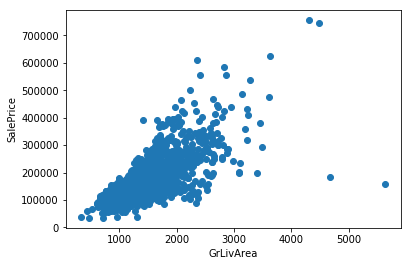

In [84]:
fig,ax=plt.subplots()
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [5]:
train.drop(train[(train["GrLivArea"]>4000)&(train["SalePrice"]<300000)].index,inplace=True)

In [6]:
full=pd.concat([train,test], ignore_index=True)

In [7]:
full.drop(['Id'],axis=1, inplace=True)
full.shape

(2917, 80)

In [9]:
null_vale = full.isnull().sum()
null_vale[null_vale>0].sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Electrical         1
BsmtUnfSF          1
Exterior1st        1
Exterior2nd        1
TotalBsmtSF        1
GarageCars         1
BsmtFinSF2         1
BsmtFinSF1         1
KitchenQual        1
SaleType           1
GarageArea         1
dtype: int64

In [10]:
full["LotAreaCut"] = pd.qcut(full.LotArea,10)

In [11]:
full['LotFrontage']=full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
full['LotFrontage']=full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [12]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    full[col].fillna(0, inplace=True)

In [13]:
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    full[col].fillna("None", inplace=True)

In [14]:
cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    full[col].fillna(full[col].mode()[0], inplace=True)

In [15]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

## Feature Engineering

In [16]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    full[col]=full[col].astype(str)

In [19]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 
                                                     'Family':2, 'Normal':3, 'Partial':4})  

In [20]:
map_values()

In [21]:
full.drop("LotAreaCut",axis=1,inplace=True)
full.drop(['SalePrice'],axis=1,inplace=True)

In [22]:
full.shape

(2917, 101)

In [23]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [24]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [25]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [26]:
full_data = full.copy()

In [27]:
data_pipe = pipe.fit_transform(full_data)

In [28]:
scaler = RobustScaler()

In [29]:
n_train=train.shape[0]
X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= train.SalePrice

Text(0.5,1,'SalePrice distribution')

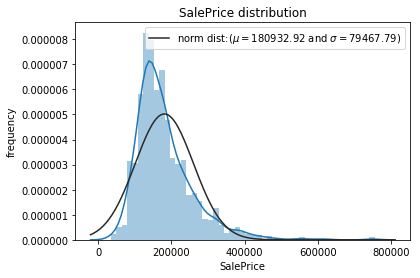

In [77]:
(mu,sigma)=norm.fit(train['SalePrice'])

sns.distplot(train['SalePrice'],fit=norm)
plt.legend(['norm dist:($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('frequency')
plt.title('SalePrice distribution')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74213.25959976626, 180932.91906721535, 0.9320154492892366))

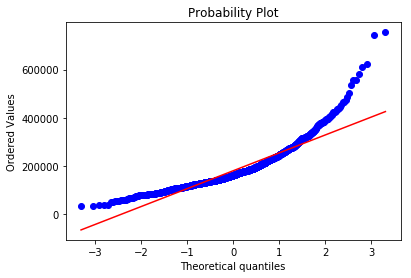

In [78]:
stats.probplot(train['SalePrice'],plot=plt)

In [30]:
X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

Text(0.5,1,'SalePrice distribution')

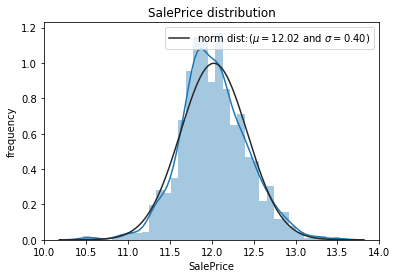

In [79]:
(mu,sigma)=norm.fit(y_log)

sns.distplot(y_log,fit=norm)
plt.legend(['norm dist:($\mu=${:.2f} and $\sigma=${:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('frequency')
plt.title('SalePrice distribution')

((array([-3.3047554 , -3.04752042, -2.90446807, ...,  2.90446807,
          3.04752042,  3.3047554 ]),
  array([10.46024211, 10.47194981, 10.54270639, ..., 13.34550693,
         13.5211395 , 13.53447303])),
 (0.39853206929765145, 12.024008660964794, 0.9953918648311372))

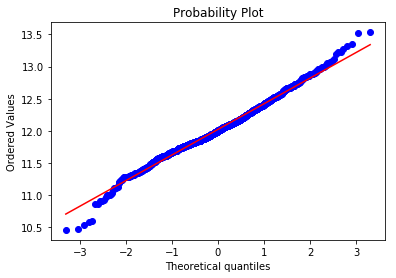

In [80]:
stats.probplot(y_log,plot=plt)

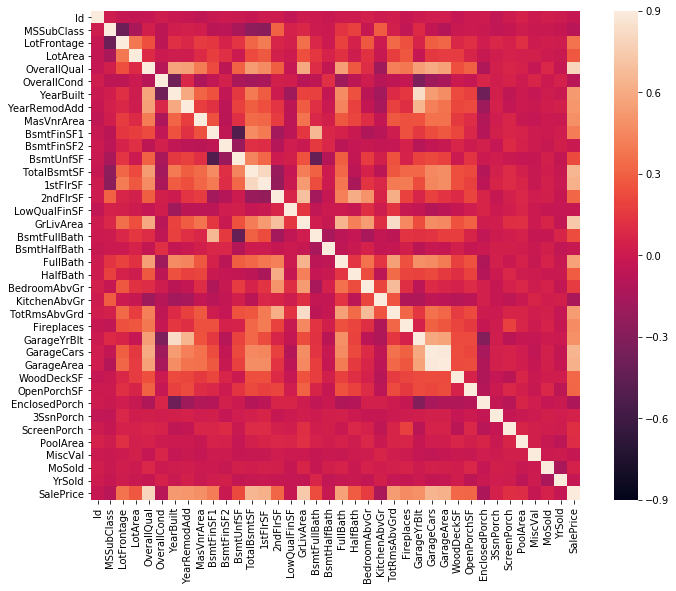

In [32]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.9,vmin=-0.9,square=True, linecolor='white')

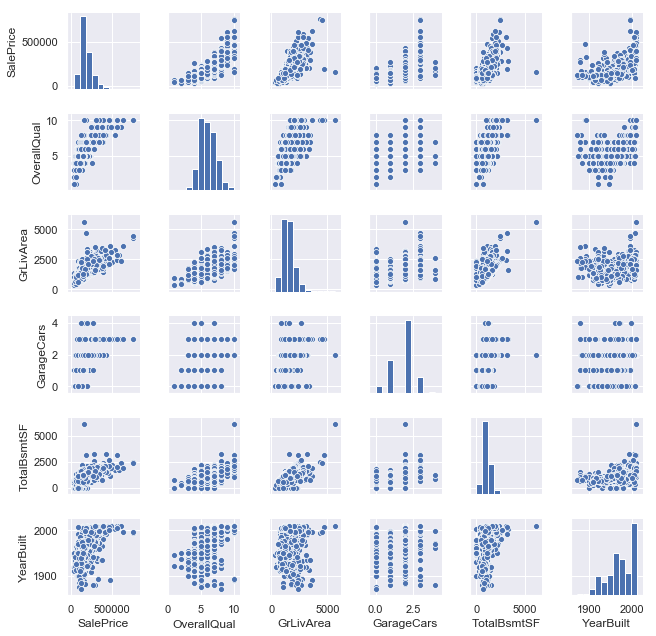

In [86]:
sns.set()
cols=['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']
train[cols]
sns.pairplot(train[cols], size = 1.5)
plt.show()

## Feature Selection

In [33]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

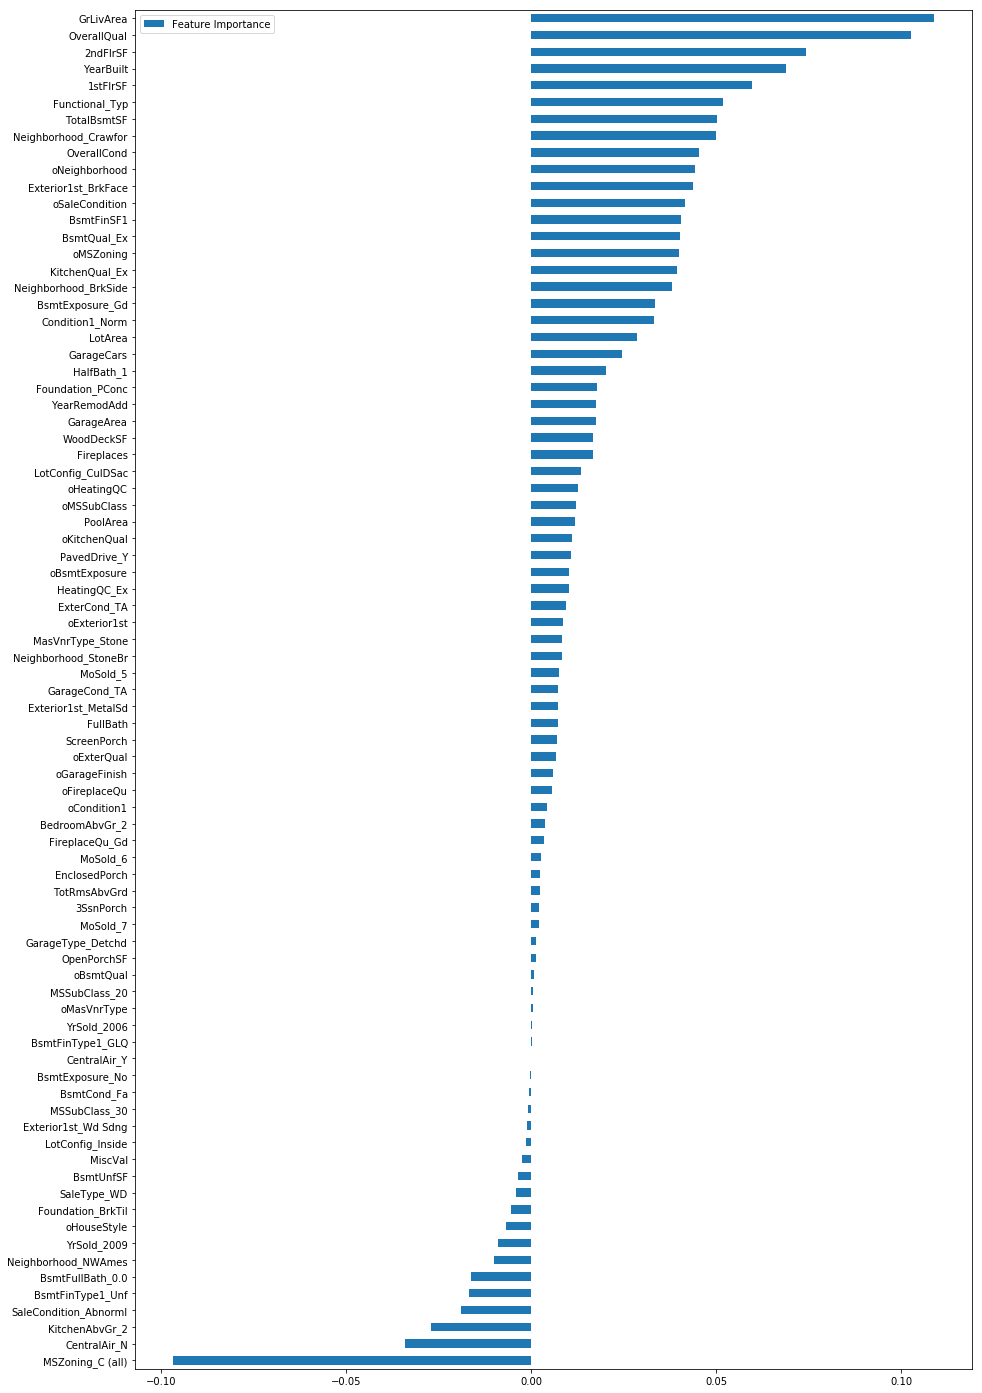

In [36]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.show()

In [37]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
            
            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]
            
           
            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] 
            + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            
            return X

In [38]:
pipe = Pipeline([
    ('labenc', labelenc()),
    ('add_feature', add_feature(additional=2)),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [39]:
full_pipe = pipe.fit_transform(full)

In [41]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

In [42]:
X_scaled = scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = scaler.transform(test_X)

In [43]:
pca = PCA(n_components=410)

In [44]:
X_scaled=pca.fit_transform(X_scaled)
test_X_scaled = pca.transform(test_X_scaled)

In [45]:
X_scaled.shape, test_X_scaled.shape

((1458, 410), (1459, 410))

## Model Selection

In [46]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [47]:
models = [LinearRegression(),
          Ridge(),
          Lasso(alpha=0.01,max_iter=10000),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(),
          LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),
          SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),
          XGBRegressor()]

names = ["LR", 
         "Ridge", 
         "Lasso", 
         "RF", 
         "GBR", 
         "SVR", 
         "LinSVR", 
         "Ela",
         "SGD",
         "Bay",
         "Ker",
         "Extra",
         "Xgb"]

In [48]:
name_list = []
mean_list = []
std_list = []
for name, model in zip(names, models):
    score = rmse_cv(model, X_scaled, y_log)
    if (name!='LR'):
        name_list.append(name)
        mean_list.append(score.mean())
        std_list.append(score.std())
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 2028014570.625926, 2471102993.0957
Ridge: 0.117671, 0.0091
Lasso: 0.121509, 0.0060
RF: 0.141923, 0.0075
GBR: 0.125261, 0.0084
SVR: 0.112776, 0.0047
LinSVR: 0.121700, 0.0069
Ela: 0.111325, 0.0059
SGD: 0.154716, 0.0125
Bay: 0.110615, 0.0060
Ker: 0.109322, 0.0055
Extra: 0.137150, 0.0055
Xgb: 0.126068, 0.0066


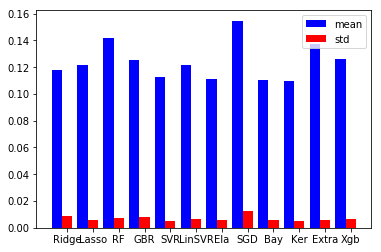

In [49]:
x =list(range(len(mean_list)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, mean_list, width=width, label='mean',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, std_list, width=width, label='std',tick_label = name_list,fc = 'r')
plt.legend()
plt.show()


In [50]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [51]:
grid(Lasso()).grid_get(X_scaled,y_log,{'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0005, 'max_iter': 10000} 0.11150967998664903
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.111600        0.001374
1  {'alpha': 0.0005, 'max_iter': 10000}         0.111510        0.001344
2  {'alpha': 0.0007, 'max_iter': 10000}         0.111796        0.001293
3  {'alpha': 0.0006, 'max_iter': 10000}         0.111589        0.001326
4  {'alpha': 0.0009, 'max_iter': 10000}         0.112193        0.001217
5  {'alpha': 0.0008, 'max_iter': 10000}         0.111973        0.001241


In [54]:
grid(Ridge()).grid_get(X_scaled,y_log,{'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 60} 0.11024144264582893
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.110413        0.001268
1  {'alpha': 40}         0.110344        0.001249
2  {'alpha': 45}         0.110296        0.001234
3  {'alpha': 50}         0.110266        0.001222
4  {'alpha': 55}         0.110248        0.001212
5  {'alpha': 60}         0.110241        0.001204
6  {'alpha': 65}         0.110243        0.001197
7  {'alpha': 70}         0.110252        0.001191
8  {'alpha': 80}         0.110288        0.001183
9  {'alpha': 90}         0.110342        0.001176


In [55]:
grid(SVR()).grid_get(X_scaled,y_log,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 14, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10833153619309642
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108766   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108424   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108748   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108428   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108720   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108376   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108716   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.108365   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.108673   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.108352   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.108695   
11  {'C': 13, 'epsilon': 0.009

In [56]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(X_scaled,y_log,param_grid)

{'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'kernel': 'polynomial'} 0.10831499261516284
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...         0.108315   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...         0.108556   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...         0.108993   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...         0.108445   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...         0.108325   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...         0.108553   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...         0.108808   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...         0.108346   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...         0.108410   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...         0.109290   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...         0.108477   
11  {'alpha': 0.5, 'coef0'

In [57]:
grid(ElasticNet()).grid_get(X_scaled,y_log,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.005, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11133778859686996
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.116362   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.115801   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.112629   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.111900   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.111652   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.114586   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.113981   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.111878   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.111562   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.111546   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.111357   
11  {'alpha': 0.004, 'l1_ratio': 0.1, 

In [58]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [59]:
lasso = Lasso(alpha=0.0005,max_iter=10000)
ridge = Ridge(alpha=60)
svr = SVR(gamma= 0.0004,kernel='rbf',C=13,epsilon=0.009)
ker = KernelRidge(alpha=0.2 ,kernel='polynomial',degree=3 , coef0=0.8)
ela = ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000)
bay = BayesianRidge()

In [60]:
w1 = 0.02
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.03
w6 = 0.2

In [61]:
weight_avg = AverageWeight(mod = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])

In [62]:
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()

(array([0.10432182, 0.10948003, 0.11842689, 0.10024067, 0.10627556]),
 0.10774899616043135)

In [63]:
weight_avg = AverageWeight(mod = [svr,ker],weight=[0.5,0.5])

In [64]:
rmse_cv(weight_avg,X_scaled,y_log),  rmse_cv(weight_avg,X_scaled,y_log).mean()

(array([0.10282876, 0.10921807, 0.11768897, 0.09864827, 0.10540418]),
 0.10675764960824634)

In [65]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [66]:
a = Imputer().fit_transform(X_scaled)
b = Imputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [67]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [68]:
print(rmse_cv(stack_model,a,b))
print(rmse_cv(stack_model,a,b).mean())

[0.10350263 0.1099501  0.11725659 0.09837364 0.10414941]
0.10664647478203734


In [69]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X_scaled)
X_train_stack.shape, a.shape

((1458, 6), (1458, 410))

In [70]:
X_train_stack

array([[12.22253919, 12.21771379, 12.22083996, 12.22088251, 12.21837444,
        12.21476464],
       [12.2057171 , 12.19920734, 12.16662855, 12.14997437, 12.2023972 ,
        12.19774491],
       [12.26791463, 12.26938061, 12.2706377 , 12.27447083, 12.265525  ,
        12.26051087],
       ...,
       [12.46168747, 12.4655828 , 12.47632503, 12.47540776, 12.46387117,
        12.48831052],
       [11.81485674, 11.81927454, 11.85092373, 11.8145936 , 11.81682653,
        11.8332567 ],
       [11.88449581, 11.89265856, 11.88354625, 11.89104196, 11.88881213,
        11.89326092]])

In [71]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X_scaled,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 416), (1459, 416))

In [72]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.09910587 0.10538674 0.11217189 0.09412545 0.0987788 ]
0.10191375064917033


In [73]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [74]:
stack_model.fit(a,b)

stacking(meta_model=KernelRidge(alpha=0.2, coef0=0.8, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
     mod=[Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=No...True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)])

In [75]:
pred = np.exp(stack_model.predict(test_X_scaled))

In [76]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':pred})
result.to_csv("submission.csv",index=False)